In [1]:
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload 
%autoreload 2

In [2]:
import os
import numpy as np
import subprocess
import eugene as eu

Global seed set to 13


GPU is available: True
Number of GPUs: 1
Current GPU: 0
GPUs: Quadro RTX 5000


In [25]:
eu.settings.dataset_dir = "/cellar/users/aklie/projects/EUGENe/tests/notebooks/implement/gkm_data"
eu.settings.logging_dir = "/cellar/users/aklie/projects/EUGENe/tests/notebooks/implement/gkm_logs"

# SeqData to gkmSVM Fasta's

In [3]:
sdata = eu.datasets.random1000()

In [4]:
eu.pp.ohe_seqs_sdata(sdata)
eu.pp.train_test_split_sdata(sdata)

One-hot encoding sequences:   0%|          | 0/1000 [00:00<?, ?it/s]

SeqData object modified:
	ohe_seqs: None -> 1000 ohe_seqs added
SeqData object modified:
    seqs_annot:
        + train_val


In [5]:
seqs = sdata.seqs
seq = seqs[0]

In [6]:
ohe_seqs = sdata.ohe_seqs
ohe_seq = ohe_seqs[0]

In [7]:
seq_len = len(seqs[0])

In [9]:
def gc_content_seq(seq, ohe=False):
    if ohe:
        return np.sum(ohe_seq[1:3, :])/ohe_seq.shape[1]
    else:
        return (seq.count("G") + seq.count("C"))/len(seq)

In [10]:
def gc_content_seqs(seqs, ohe=False):
    if ohe:
        return np.sum(ohe_seqs[:, 1:3, :], axis=1).sum(axis=1)/seq_len
    else:
        return np.array([gc_content_seq(seq) for seq in seqs])

In [11]:
eu.pp.gc_content_seq(seq), eu.pp.gc_content_seq(ohe_seq, ohe=True)

(0.47, 0.47)

In [14]:
eu.pp.gc_content_seqs(seqs)[:5], eu.pp.gc_content_seqs(ohe_seqs, ohe=True)[:5]

(array([0.47, 0.54, 0.56, 0.49, 0.52]), array([0.47, 0.54, 0.56, 0.49, 0.52]))

In [13]:
def gc_content_seqs_sdata(
    sdata,
    copy=False
):
    sdata = sdata.copy() if copy else sdata
    if sdata.ohe_seqs is not None:
        sdata["gc_content"] = gc_content_seqs(sdata.ohe_seqs, ohe=True)
    elif sdata.seqs is not None:
        sdata["gc_content"] = gc_content_seqs(sdata.ohe_seqs, ohe=True)
    else:
        raise ValueError("No sequences to calculate gc_content on")
    return sdata if copy else None

In [16]:
eu.pp.gc_content_seqs_sdata(sdata)

SeqData object modified:
    seqs_annot:
        + gc_content


In [16]:
def to_gkmSVM_fasta(
    sdata, 
    target_key,
    train_key=None,
    task="binary_classification",
    file_name="seqs"
):
    """Utility function to generate a fasta file from an sdata object
    
    Useful for running gkm-SVM. If the task is binary classfiction, the seqs are
    split into two files, one for positive label and one for negative label. If the task 
    is regression, the seqs are written to a single file and the target values are written
    to a single file.

    Parameters
    ----------
    sdata : SeqData
        SeqData object containing sequences and target values
    target_key : str
        Key for the target values in the sdata object
    train_key : str, optional
        Key for the train/test split in the sdata object, by default None
    task : str, optional
        Task type, by default "binary_classification"
    file_name : str, optional
        Name of the fasta file, by default "seqs"
    
    Returns
    -------
    None
    """
    if target_key is None:
            raise ValueError("target_key must be specified")
    if train_key is not None:
        train = sdata[sdata[train_key] == True]
        test = sdata[sdata[train_key] == False]
    if task == "binary_classification":
        if train_key is not None:
            train_pos = train[train[target_key] == 1]
            train_neg = train[train[target_key] == 0]
            test_pos = test[test[target_key] == 1]
            test_neg = test[test[target_key] == 0]
            seqs_to_save = [train_pos.seqs, train_neg.seqs, test_pos.seqs, test_neg.seqs]
            ids_to_save = [train_pos.seqs_annot.index, train_neg.seqs_annot.index, test_pos.seqs_annot.index, test_neg.seqs_annot.index]
            file_names = [f"{file_name}_train_pos.fasta", f"{file_name}_train_neg.fasta", f"{file_name}_test_pos.fasta", f"{file_name}_test_neg.fasta"]
        else:
            pos = sdata[sdata[target_key] == 1]
            neg = sdata[sdata[target_key] == 0]
            seqs_to_save = [pos.seqs, neg.seqs]
            ids_to_save = [pos.seqs_annot.index, neg.seqs_annot.index]
            file_names = [f"{file_name}_pos.fasta", f"{file_name}_neg.fasta"]
        targets_to_save = None
    elif task == "regression":
        if train_key is not None:
            seqs_to_save = [train.seqs, test.seqs]
            ids_to_save = [train.seqs_annot.index, test.seqs_annot.index]
            targets_to_save = [train[target_key].values, test[target_key].values]
            file_names = [f"{file_name}_train.fasta", f"{file_name}_test.fasta"]
        else:
            seqs_to_save = [sdata.seqs]
            ids_to_save = [sdata.seqs_annot.index]
            file_names = [f"{file_name}.fasta"]
            targets_to_save = [sdata[target_key].values]

    for seqs, ids, file_name in zip(seqs_to_save, ids_to_save, file_names):
        with open(file_name, "w") as f:
            for j, seq in enumerate(seqs):
                f.write(">" + ids[j] + "\n" + seqs[j] + "\n")
    if targets_to_save is not None:
        for targets, file_name in zip(targets_to_save, file_names):
            with open(file_name.replace(".fasta", ".targets"), "w") as f:
                for target in targets:
                    f.write(str(target) + "\n")

In [24]:
eu.external.gkm_svm.to_fasta(sdata, "label_0", train_key="train_val", task="binary_classification", file_name="seqs")

# Fit on these files and add training predictions to SeqData
Will need to make sure IDs line up in all cases

In [54]:
import threading
param_dict = {
    "binary_classification": 0, 
    "regression": 3
}  # gkm-SVM parameter for task type

def fit(
    sdata,
    target_key,
    train_key=None,
    task="binary_classification",
    kernel_type="gkm",
    word_length=11,
    informative_columns=7,
    mismatches=3,
    gamma=1.0,
    decay_M=50,
    half_life=50,
    reverse_complement=False,
    regularization_strength=1.0,
    epsilon=0.001,
    positive_weight=1.0,
    cached_mem_size=8000,
    threads=None,
    verbose=2,
    data_dir=None,
    log_dir=None,
    name="seqs",
    prefix="",
    suffix=""
):
    data_dir = data_dir if data_dir is not None else eu.settings.dataset_dir
    log_dir = log_dir if log_dir is not None else eu.settings.logging_dir
    os.makedirs(log_dir) if not os.path.exists(log_dir) else None
    threads = threads if threads is not None else threading.active_count() - 1
    if task == "binary_classification":
        if train_key is not None:
            file1_name = os.path.join(data_dir, f"{name}_train_pos.fasta")
            file2_name = os.path.join(data_dir, f"{name}_train_neg.fasta")  
        else:
            file1_name = os.path.join(data_dir, f"{name}_pos.fasta")
            file2_name = os.path.join(data_dir, f"{name}_neg.fasta")
    elif task == "regression":
        if train_key is not None:
            file1_name = os.path.join(data_dir, f"{name}_train.fasta")
            file2_name = os.path.join(data_dir, f"{name}_train.targets") 

        else:
            file1_name = os.path.join(data_dir, f"{name}.fasta")
            file2_name = os.path.join(data_dir, f"{name}.targets")
    if os.path.exists(file1_name) and os.path.exists(file2_name):
        print("Train files already exist, skipping generation")
    else:
        to_gkmSVM_fasta(sdata, target_key, train_key=train_key, task=task, name=name)   
    print("Fitting model")
    log_file = open(os.path.join(log_dir, f"{prefix}{name}_fit{suffix}.log"), "w")
    process = subprocess.Popen(
        [
            'gkmtrain', 
            file1_name, # positive training file
            file2_name, # negative training file
            os.path.join(log_dir, prefix+name+suffix), # output file name
            '-y', str(param_dict[task]), # task type
            '-t', kernel_type, # kernel type
            '-l', str(word_length), # word length
            '-k', str(informative_columns), # number of informative columns
            '-d', str(mismatches), # number of mismatches
            '-g', str(gamma), # gamma
            '-M', str(decay_M), # decay M
            '-H', str(half_life), # half life
            #'-R', str(reverse_complement), # reverse complement
            '-c', str(regularization_strength), # regularization strength
            '-e', str(epsilon), # epsilon
            '-w', str(positive_weight), # positive weight
            #'-m', str(cached_mem_size), # cached memory size
            '-T', str(threads), # number of threads
            '-v', str(verbose), # verbose
        ],
                    stdout=log_file,
                    stderr=subprocess.PIPE
    )
    stdout, stderr = process.communicate()
    if stderr.decode("utf-8") != "":
        err_file = open(os.path.join(log_dir, f"{prefix}{name}_fit{suffix}.err"), "w")
        err_file.write(stderr.decode("utf-8"))
        raise Exception("Error in gkmtrain, check error file: " + os.path.join(log_dir, f"{prefix}{name}_fit{suffix}.err"))
    print("Model fit, log file saved to", os.path.join(log_dir, f"{prefix}{name}_fit{suffix}.log"))
    log_file.close()
    return

In [33]:
import threading
import math

9

In [55]:
num = threading.active_count()
num = 3

In [56]:
4**(math.floor(math.log(num, 4)))

1

In [ ]:
(4 * int((threading.active_count() / 4)))

In [28]:
(4 * int((threading.active_count() / 4)))

8

In [32]:
int(12**(1/2))

3

In [64]:
eu.external.gkm_svm.fit(
    sdata, 
    target_key="label_0", 
    task="binary_classification", 
    train_key="train_val", 
    name="seqs", 
    prefix="trainset_", 
    suffix="_binary_classification"
)

Train files already exist, skipping generation
Fitting model
Model fit, log file saved to /cellar/users/aklie/projects/EUGENe/tests/notebooks/implement/gkm_logs/trainset_seqs_fit_binary_classification.log


In [49]:
fit(
    sdata, 
    target_key="label_0", 
    task="binary_classification", 
    train_key="train_val", 
    file_name="seqs", 
    prefix="trainset_", 
    suffix="_binary_classification"
)

Train files already exist, skipping generation
Fitting model
Model fit, log file saved to /mnt/beegfs/users/aklie/projects/EUGENe/tests/notebooks/implement/gkm_logs/trainset_seqs_fit_binary_classification.log


In [52]:
fit(
    sdata, 
    "label_0", 
    task="binary_classification", 
    file_name="seqs",
    prefix="all_",    
    suffix="_binary_classification"
)

Train files already exist, skipping generation
Fitting model
Model fit, log file saved to /mnt/beegfs/users/aklie/projects/EUGENe/tests/notebooks/implement/gkm_logs/all_seqs_fit_binary_classification.log


In [55]:
fit(
    sdata, 
    "label_0", 
    task="regression", 
    train_key="train_val", 
    file_name="seqs",
    prefix="trainset_",
    suffix="_regression"
)

Train files already exist, skipping generation
Fitting model
Model fit, log file saved to /mnt/beegfs/users/aklie/projects/EUGENe/tests/notebooks/implement/gkm_logs/trainset_seqs_fit_regression.log


In [56]:
fit(
    sdata, 
    "label_0", 
    task="regression", 
    file_name="seqs",
    prefix="all_",
    suffix="_regression"
)

Train files already exist, skipping generation
Fitting model
Model fit, log file saved to /mnt/beegfs/users/aklie/projects/EUGENe/tests/notebooks/implement/gkm_logs/all_seqs_fit_regression.log


# Predict function for new sequences

In [94]:
def predict(
    model,
    sdata=None,
    file_names=None,
    data_dir=None,
    log_dir=None,
    out_dir=None,
    file_label=None,
    threads=None,
    prefix="",
    suffix="",
    verbose=2
):  
    data_dir = data_dir if data_dir is not None else eu.settings.dataset_dir
    log_dir = log_dir if log_dir is not None else eu.settings.logging_dir
    out_dir = out_dir if out_dir is not None else eu.settings.output_dir
    os.makedirs(out_dir) if not os.path.exists(out_dir) else None
    file_label = file_label if file_label is not None else "sdata"
    threads = threads if threads is not None else threading.active_count() - 1
    
    # Check if model exists
    print(os.path.join(log_dir, prefix + model + suffix+".model.txt"))
    if not os.path.exists(model):
        if os.path.exists(os.path.join(log_dir, model + ".model.txt")):
            model = os.path.join(log_dir, model + "model.txt")
        elif os.path.exists(os.path.join(log_dir, prefix + model + suffix+".model.txt")):
            model = os.path.join(log_dir, prefix+model+suffix + ".model.txt")
        else:
            raise Exception("Model file does not exist")

    if sdata is not None:
        seqs = sdata.seqs
        ids = sdata.seqs_annot.index
        with open(prefix+file_label+suffix+".fasta", "w") as f:
            for j, seq in enumerate(seqs):
                f.write(">" + ids[j] + "\n" + seqs[j] + "\n")
        file_names = [prefix+file_label+suffix+".fasta"]
    else:
        assert file_names is not None, "Either sdata or file_names must be provided"
        if isinstance(file_names, str):
            file_names = [file_names]

    for file_name in file_names:
        if os.path.exists(os.path.join(data_dir, file_name)):
                file_name = os.path.join(data_dir, file_name)
        if not os.path.exists(file_name):
            raise Exception("Data file does not exist: " + file_name)
        log_file = open(os.path.join(out_dir, f"{prefix}{file_label}_predict{suffix}.log"), "w")
        process = subprocess.Popen(
            [
                'gkmpredict', 
                file_name, # seqs to test
                model, # model file
                os.path.join(out_dir, prefix+file_label+suffix+"_predictions.txt"), # output file name
                '-T', str(threads), # number of threads
                '-v', str(verbose), # verbose
            ],
                        stdout=log_file,
                        stderr=subprocess.PIPE
        )
        stdout, stderr = process.communicate()
        if stderr.decode("utf-8") != "":
            err_file = open(os.path.join(out_dir, f"{prefix}{file_label}_predict{suffix}.err"), "w")
            err_file.write(stderr.decode("utf-8"))
            raise Exception("Error in gkmpredict, check error file: " + os.path.join(log_dir, f"{prefix}{file_name}predict{suffix}.err"))
        print("Predictions saved to", os.path.join(out_dir, prefix+file_label+suffix+"_predictions.txt"))
        log_file.close()

    if sdata is not None:
        f = open(os.path.join(out_dir, prefix+file_label+suffix+"_predictions.txt"), "r")
        d = [float(x.strip().split('\t')[1]) for x in f]
        f.close()
        sdata.seqs_annot[f"{file_label}_prediction"] = d
    return
        

In [65]:
eu.settings.output_dir = "/cellar/users/aklie/projects/EUGENe/tests/notebooks/implement/gkm_output"

In [ ]:
predict(

In [66]:
eu.external.gkm_svm.predict(
    model="seqs",
    file_names="seqs.fasta",
    prefix="trainset_",
    suffix="_binary_classification",
    file_label="seqs"
)

/cellar/users/aklie/projects/EUGENe/tests/notebooks/implement/gkm_logs/trainset_seqs_binary_classification.model.txt
Predictions saved to /cellar/users/aklie/projects/EUGENe/tests/notebooks/implement/gkm_output/trainset_seqs_binary_classification_predictions.txt


In [95]:
predict(
    model="seqs",
    sdata=sdata,
    prefix="trainset_",
    suffix="_binary_classification",
    file_label="sdata"
)

/mnt/beegfs/users/aklie/projects/EUGENe/tests/notebooks/implement/gkm_logs/trainset_seqs_binary_classification.model.txt
Predictions saved to /mnt/beegfs/users/aklie/projects/EUGENe/tests/notebooks/implement/gkm_output/trainset_sdata_binary_classification_predictions.txt


In [96]:
sdata.seqs_annot.head()

,label_0,label_1,label_2,label_3,label_4,label_5,label_6,label_7,label_8,label_9,...,activity_3,activity_4,activity_5,activity_6,activity_7,activity_8,activity_9,train_val,gc_content,sdata_prediction
seq000,0,0,1,1,0,1,0,0,0,1,...,0.731073,0.001675,0.016131,0.042079,0.285377,0.800250,0.436581,True,0.47,-0.999734
seq001,1,0,1,0,0,1,1,1,1,1,...,0.847881,0.118016,0.892414,0.107932,0.106812,0.881007,0.960471,True,0.54,1.000070
seq002,1,0,0,0,0,0,1,1,1,0,...,0.255944,0.187834,0.772877,0.425402,0.725678,0.311773,0.665010,True,0.56,1.000250
seq003,1,0,1,0,0,1,1,0,0,0,...,0.876968,0.748678,0.216482,0.248412,0.126978,0.239007,0.833106,False,0.49,-0.107020
seq004,0,1,0,0,1,1,0,1,1,0,...,0.665125,0.186673,0.826641,0.789425,0.158561,0.645586,0.635246,False,0.52,0.233125


# Explain function

In [115]:
mode_dict = {
    "importances": 0
}
def explain(
    model,
    sdata=None,
    explanation_mode="importances",
    file_names=None,
    data_dir=None,
    log_dir=None,
    out_dir=None,
    file_label=None,
    threads=None,
    prefix="",
    suffix="",
    verbose=2
):  
    data_dir = data_dir if data_dir is not None else eu.settings.dataset_dir
    log_dir = log_dir if log_dir is not None else eu.settings.logging_dir
    out_dir = out_dir if out_dir is not None else eu.settings.output_dir
    os.makedirs(out_dir) if not os.path.exists(out_dir) else None
    file_label = file_label if file_label is not None else "sdata"
    threads = threads if threads is not None else threading.active_count() - 1
    
    # Check if model exists
    print(os.path.join(log_dir, prefix + model + suffix+".model.txt"))
    if not os.path.exists(model):
        if os.path.exists(os.path.join(log_dir, model + ".model.txt")):
            model = os.path.join(log_dir, model + "model.txt")
        elif os.path.exists(os.path.join(log_dir, prefix + model + suffix+".model.txt")):
            model = os.path.join(log_dir, prefix+model+suffix + ".model.txt")
        else:
            raise Exception("Model file does not exist")

    if sdata is not None:
        seqs = sdata.seqs
        ids = sdata.seqs_annot.index
        with open(prefix+file_label+suffix+".fasta", "w") as f:
            for j, seq in enumerate(seqs):
                f.write(">" + ids[j] + "\n" + seqs[j] + "\n")
        file_names = [prefix+file_label+suffix+".fasta"]
    else:
        assert file_names is not None, "Either sdata or file_names must be provided"
        if isinstance(file_names, str):
            file_names = [file_names]

    for file_name in file_names:
        if os.path.exists(os.path.join(data_dir, file_name)):
                file_name = os.path.join(data_dir, file_name)
        if not os.path.exists(file_name):
            raise Exception("Data file does not exist: " + file_name)
        log_file = open(os.path.join(out_dir, f"{prefix}{file_label}_explain{suffix}.log"), "w")
        print("running gkmexplain on", file_name, "with model", model, "and mode", mode_dict[explanation_mode])
        print(" ".join([
                'gkmexplain', 
                file_name, # seqs to test
                model, # model file
                os.path.join(out_dir, prefix+file_label+suffix+"_explanations.txt"), # output file name
                '-m', str(mode_dict[explanation_mode]), # explanation mode
                '-T', str(threads), # number of threads
                '-v', str(verbose), # verbose
            ]))
        process = subprocess.Popen(
            [
                'gkmexplain', 
                file_name, # seqs to test
                model, # model file
                os.path.join(out_dir, prefix+file_label+suffix+"_explanations.txt"), # output file name
                '-m', str(mode_dict[explanation_mode]), # explanation mode
                '-v', str(verbose), # verbose
            ],
                        stdout=log_file,
                        stderr=subprocess.PIPE
        )
        stdout, stderr = process.communicate()
        if stderr.decode("utf-8") != "":
            err_file = open(os.path.join(out_dir, f"{prefix}{file_label}_explain{suffix}.err"), "w")
            err_file.write(stderr.decode("utf-8"))
            raise Exception("Error in gkmexplain, check error file: " + os.path.join(log_dir, f"{prefix}{file_name}explain{suffix}.err"))
        print("Predictions saved to", os.path.join(out_dir, prefix+file_label+suffix+"_explanations.txt"))
        log_file.close()

    if sdata is not None:
        file = os.path.join(out_dir, prefix+file_label+suffix+"_explanations.txt")
        impscores = np.array([np.array([[float(z) for z in y.split(",")] for y in x.rstrip().split("\t")[2].split(";")]).transpose() for x in open(file, "r")]) # list of np arrays of shape (L, 4) for each sequence
        sdata.uns[f"{file_label}_imps"] = impscores
    return 

In [68]:
eu.external.gkm_svm.explain(
    model="seqs",
    sdata=sdata,
    prefix="trainset_",
    suffix="_binary_classification",
    file_label="sdata"
)

/cellar/users/aklie/projects/EUGENe/tests/notebooks/implement/gkm_logs/trainset_seqs_binary_classification.model.txt
running gkmexplain on trainset_sdata_binary_classification.fasta with model /cellar/users/aklie/projects/EUGENe/tests/notebooks/implement/gkm_logs/trainset_seqs_binary_classification.model.txt and mode 0
gkmexplain trainset_sdata_binary_classification.fasta /cellar/users/aklie/projects/EUGENe/tests/notebooks/implement/gkm_logs/trainset_seqs_binary_classification.model.txt /cellar/users/aklie/projects/EUGENe/tests/notebooks/implement/gkm_output/trainset_sdata_binary_classification_explanations.txt -m 0 -T 4 -v 2
Predictions saved to /cellar/users/aklie/projects/EUGENe/tests/notebooks/implement/gkm_output/trainset_sdata_binary_classification_explanations.txt


In [69]:
sdata.uns["sdata_imps"].shape

(1000, 4, 100)

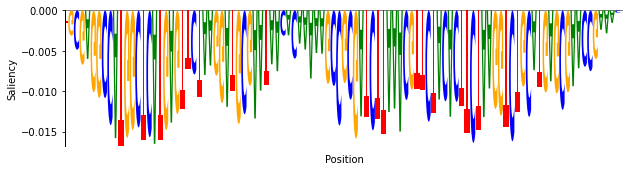

In [70]:
eu.pl.seq_track(
    sdata,
    seq_id="seq000",
    uns_key = "sdata_imps",
)